In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/Users/piotr/Documents/studia/mgr/CVLab/cl-teacher-adaptation


/Users/piotr/Documents/studia/mgr/CVLab/cl-teacher-adaptation/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%cd cl-adaptation/

[Errno 2] No such file or directory: 'cl-adaptation/'
/Users/piotr/Documents/studia/mgr/CVLab/cl-teacher-adaptation


/Users/piotr/Documents/studia/mgr/CVLab/cl-teacher-adaptation/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [3]:
from dataclasses import dataclass, field
from functools import partial
from pathlib import Path
import re
from typing import List
from matplotlib import pyplot as plt
import numpy as np
import torch


def parse_path(filename):
    match = re.match(r".*dt:(\d+)_t:(\d+)_", filename)
    if match:
        data_task = int(match.group(1))
        task = int(match.group(2))
    else:
        raise ValueError("Filename format is incorrect")
    return data_task, task


@dataclass
class Weight:
    filename: str
    W: torch.Tensor
    b: torch.Tensor
    varcov: None
    task: int
    data_task: int

    @classmethod
    def from_path(cls, path):
        path = Path(path)

        ckpt = torch.load(path, map_location="cpu")["state_dict"]

        W = ckpt["linear_layer.weight"].flatten().numpy()
        b = ckpt["linear_layer.bias"].numpy()

        data_task, task = parse_path(path.name)
        varcov = None

        return cls(path.name, W, b, varcov, task, data_task)

    def get_item(self, kind="W"):
        return self.W if kind == "W" else self.b


def get_weigths_and_sort(directory_path: Path) -> List[Weight]:
    paths = list(directory_path.rglob("*.ckpt"))

    weights = [Weight.from_path(path) for path in paths]
    weights = sorted(weights, key=lambda x: x.filename)
    return weights


def get_subsequents(weights):
    nth = list(filter(lambda x: x.data_task - x.task == 1, weights))
    prev_nth = list(filter(lambda x: x.data_task - x.task == 0, weights))
    return nth, prev_nth


def get_zeros(weights):
    all_weights = list(filter(lambda x: x.task == 0, weights))

    prev_nth = [all_weights[0]] * (len(all_weights) - 1)
    nth = all_weights[1:]
    return nth, prev_nth


def get_diffs_W(weights, func):
    nth, prev_nth = func(weights)

    wds = np.asarray(list(map(lambda x: x.W.flatten(), nth)))
    -np.asarray(list(map(lambda x: x.W.flatten(), prev_nth)))
    return wds


def get_diffs_b(weights, func):
    nth, prev_nth = func(weights)

    wds = np.asarray(list(map(lambda x: x.b, nth)))
    -np.asarray(list(map(lambda x: x.b, prev_nth)))
    return wds


def plot(reg, noreg, name, *args, **kwargs):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
    for i in range(4):
        # Determine subplot indices
        row = i // 2
        col = i % 2

        # Plot histogram for the current dataset
        axs[row, col].hist(
            noreg[i], bins=kwargs["bins"], alpha=0.5, label="noreg", density=True
        )
        axs[row, col].hist(
            reg[i], bins=kwargs["bins"], alpha=0.5, label="reg", density=True
        )
        axs[row, col].set_title(f"After task {i+1}")
        axs[row, col].legend()
        plt.grid()

    fig.suptitle(name)
    plt.tight_layout()
    plt.show()

In [4]:
ckpt_dir = Path("linear_checkpoints")
weights_list = get_weigths_and_sort(ckpt_dir)

In [5]:
paths = list(ckpt_dir.iterdir())

In [6]:
def get_diffs(what):
    weights = list(filter(lambda x: what in x.filename, weights_list))
    assert len(weights) > 0
    diffs = []
    for i in range(4):
        j = i + 1
        res = weights[i].get_item("W") - weights[j].get_item("W")
        diffs.append(res)
    return diffs

In [7]:
def get_diffs_zero(what):
    weights = list(filter(lambda x: what in x.filename, weights_list))
    assert len(weights) > 0
    diffs = []
    for i in range(1, 5):
        res = weights[0].get_item("W") - weights[i].get_item("W")
        diffs.append(res)
    return diffs

/var/folders/4_/s_rxdxsd00j5rpk8jz76d7mh0000gn/T/ipykernel_3223/3831524298.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Set3")


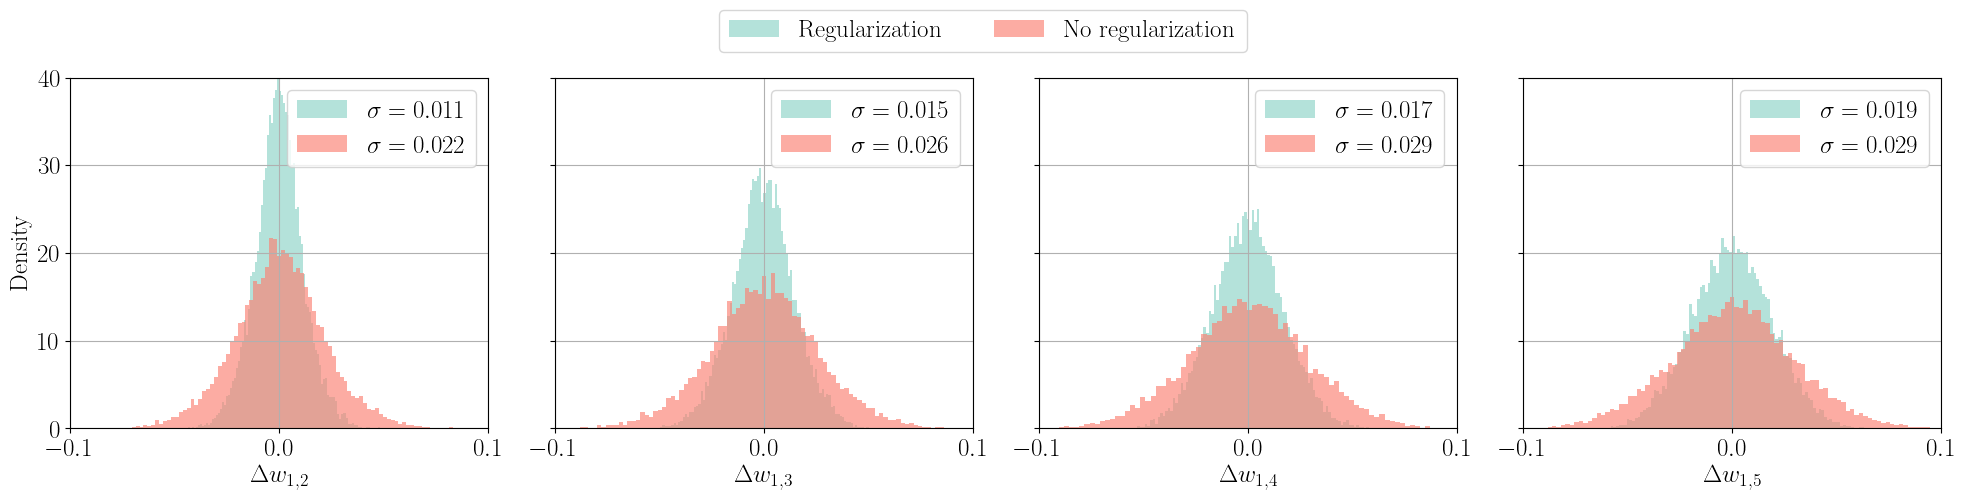

In [84]:
hist_kw = {"bins": 100, "density": True, "alpha": 0.65}

methods = ["finetuning"]
method_mapping = {
    "finetuning": "Finetuning",
    "replay": "Finetuning + exemplars",
    "ewc": "EWC",
    "lwf": "LwF",
}

import matplotlib as mpl
from matplotlib.cm import get_cmap

mpl.rcParams["text.usetex"] = False
mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
nice_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Times New Roman",
    "font.size": 18,
    "lines.linewidth": 3,
}
mpl.rcParams.update(nice_fonts)
save_fig_opt = {
    "dpi": 800,
    "transparent": True,
    "bbox_inches": "tight",
    "pad_inches": 0,
}

cmap = get_cmap("Set3")
colors = [cmap(0), cmap(3)]


def plot_methods(hist_kw, methods, diff_fn):
    save_path = Path("weights_hists/zeros")  # FIXME
    save_path.mkdir(parents=True, exist_ok=True)
    for method in methods:
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        for idx, ax in enumerate(axs):

            reg = diff_fn(f"{method}_reg")[idx]
            noreg = diff_fn(f"{method}_noreg")[idx]
            # legend_info = lambda x: r"$\sigma=" + str(x.std()).format(".3f") + r"$"
            legend_info = lambda x: rf"$\sigma={x.std():.3f}$"

            ax.hist(
                reg,
                **hist_kw,
                label=legend_info(reg),
                color=colors[0],
            )
            ax.hist(
                noreg,
                **hist_kw,
                label=legend_info(noreg),
                color=colors[1],
            )
            ax.set_xlabel(r"$\Delta w_{1," + str(idx + 2) + r"}$")
            ax.set_xlim([-0.1, 0.1])
            ax.set_xticks([-0.1, 0, 0.1])
            ax.set_ylim([0, 40])
            ax.grid()
            ax.legend(loc="upper right")
            if idx == 0:
                ax.set_ylabel(r"Density")
            else:
                ax.set(ylabel="", yticklabels=[])

        handles, labels = ax.get_legend_handles_labels()
        fig.legend(
            handles,
            ["Regularization", "No regularization"],
            loc="upper center",
            bbox_to_anchor=(0.5, 1.04),
            ncol=2,
        )
        # fig.tight_layout()
        fig.tight_layout(rect=[0, 0, 1, 0.95])
        fig.savefig(save_path / f"{method}.pdf", **save_fig_opt)


plot_methods(hist_kw, methods, get_diffs_zero)

In [ ]:
hist_kw = {"bins": 100, "density": True, "alpha": 0.65}

methods = ["finetuning", "replay", "ewc", "lwf"]
method_mapping = {
    "finetuning": "Finetuning",
    "replay": "Finetuning + exemplars",
    "ewc": "EWC",
    "lwf": "LWF",
}

import matplotlib as mpl
from matplotlib.cm import get_cmap

mpl.rcParams["text.usetex"] = False
mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
nice_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Times New Roman",
    "font.size": 14,
    "lines.linewidth": 3,
}
mpl.rcParams.update(nice_fonts)
save_fig_opt = {
    "dpi": 800,
    "transparent": True,
    "bbox_inches": "tight",
    "pad_inches": 0,
}

cmap = get_cmap("Set3")
colors = [cmap(0), cmap(2)]


def plot_methods(hist_kw, methods, diff_fn):
    save_path = Path("weights_hists/next")  # FIXME
    save_path.mkdir(parents=True, exist_ok=True)

    fig = plt.figure(figsize=(16, 12), layout="constrained")
    subfigs = fig.subfigures(4, 1)
    # plt.subplots_adjust(wspace=0.2, hspace=0.5)
    for method, subfig in zip(methods, subfigs):
        axs = subfig.subplots(1, 4)
        for idx, ax in enumerate(axs):
            ax.hist(
                diff_fn(f"{method}_reg")[idx],
                **hist_kw,
                label="Regularization",
                color=colors[0],
            )
            ax.hist(
                diff_fn(f"{method}_noreg")[idx],
                **hist_kw,
                label="No regularization",
                color=colors[1],
            )
            ax.set_xlim([-0.1, 0.1])
            ax.set_xticks([-0.1, 0, 0.1])
            ax.set_ylim([0, 60])
            ax.grid()
            ax.legend()
            if idx == 0:
                ax.set_ylabel(r"Density")
            else:
                ax.set(ylabel="", yticklabels=[])
        subfig.suptitle(method_mapping[method])
    # fig.tight_layout()
    fig.savefig(save_path / "next.pdf", **save_fig_opt)


plot_methods(hist_kw, methods, get_diffs)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def example_plot(ax, fontsize=12, hide_labels=False):
    pc = ax.pcolormesh(np.random.randn(30, 30), vmin=-2.5, vmax=2.5)
    if not hide_labels:
        ax.set_xlabel("x-label", fontsize=fontsize)
        ax.set_ylabel("y-label", fontsize=fontsize)
        ax.set_title("Title", fontsize=fontsize)
    return pc


np.random.seed(19680808)

fig = plt.figure(figsize=(20, 20), layout="constrained")
subfigs = fig.subfigures(4, 1, wspace=0.07)

for i, subfig in enumerate(subfigs):
    axs = subfig.subplots(1, 4, sharey=True)
    subfig.set_facecolor("0.75")
    for ax in axs:
        pc = example_plot(ax, hide_labels=True)
    subfig.suptitle(f"Row {i + 1} Title", fontsize="x-large", va="center")
    subfig.colorbar(pc, shrink=0.6, ax=axs, location="bottom")

fig.suptitle("Overall Figure Title", fontsize="xx-large")

plt.show()